In [4]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import zCurve as z
import math
import re

In [ ]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []

def calculate_morton(data_files, scales_dict, offsets_dict):
    data_files.sort()
    data_files.reverse()

    # ===============================
    # DATA FILE PROCESSING
    # ===============================
    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        print(file_path)

        # Get the file basename without extension
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        
        data = pd.read_csv(file_path, sep=";")
        data['timestamp'] = data['Time (seconds)'] + data['Time (microseconds)'] / (10**6)

        # Transformation for speed and steering angle 

        ntimestamps = len(data['timestamp'])
        ndimensions = len(scales_dict)
        tmp_matrix = np.zeros((ntimestamps, ndimensions))

        for j, data_key in enumerate(scales_dict.keys()):
            tmp_matrix[:, j] = [int(i) for i in data[data_key] * scales_dict[data_key] + offsets_dict[data_key]]

        # -------------------------------
        # Build Morton (Z-order) Index (if chosen or if building both)
        # -------------------------------
        data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=10) for x, y in zip(tmp_matrix[:,0], tmp_matrix[:,1])]
        df = pd.DataFrame(data=data)
        df.to_csv(file_path, sep=";")

    return []

def plot_morton(data_files):
    common_figsize = (6,5)
    output_dir = "results/real_data/plots"  # Folder to save plots
    os.makedirs(output_dir, exist_ok=True)

    data_files.sort()
    data_files.reverse()

    # ===============================
    # DATA FILE PROCESSING
    # ===============================
    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        print(file_path)

        # Get the file basename without extension
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        data = pd.read_csv(file_path, sep=";")


        fig, ax1 = plt.subplots(figsize=common_figsize)
        ax1.eventplot(data['Morton_Index'],
                        orientation='horizontal',
                        colors=["lightgray"],
                        alpha=0.4,
                        lineoffsets=0.5)
        ax1.set_xlabel("Morton Index")
        ax1.set_ylim((0, 1))
        ax1.tick_params(axis='y',gridOn=False, label1On=False, label2On=False)

        ax2 = ax1.twinx()
        ax2.scatter(data['Morton_Index'],
                    data['timestamp'],
                    color='black',
                    s=0.5,
                    alpha=0.8,
                    label="Timestamps")

        ax2.set_ylabel("Timestamp (s)")

        # ax1.set_xlim(0, 2000000) #set once the CSPs are analysed!

        plt.title(f"Morton CSP plot, Speed and Steering angle:\n{file_basename}")
        ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout()
        plot_morton_filename = os.path.join(output_dir, f"{file_basename}_speed_angle_morton.png")
        #plt.savefig(plot_morton_filename, bbox_inches="tight")

        plt.show()
        plt.close()

    return []

def plot_transformed_signals(data_files, scales_dict, offsets_dict):
    common_figsize = (6,5)
    output_dir = "results/real_data/plots"  # Folder to save plots
    os.makedirs(output_dir, exist_ok=True)

    data_files.sort()
    data_files.reverse()

    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        print(file_path)

        # Get the file basename without extension
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        data = pd.read_csv(file_path, sep=';')

        speed = [int(i) for i in data['Speed (m/s)'] * scales_dict['Speed (m/s)'] + offsets_dict['Speed (m/s)']]
        steering_angle = [int(i) for i in data['Steering angle (deg)'] * scales_dict['Steering angle (deg)'] + offsets_dict['Steering angle (deg)']]

        timestamps = data['timestamp']
        timestamps = timestamps.tolist()
        # Find the lane changes 
        fig, ax = plt.subplots(figsize = common_figsize)
        lanechanges = []
        tmp_vec = []
        for i, el in enumerate(timestamps):

            if i == len(timestamps) - 1:
                break

            if data['Lane change'].tolist()[i] == 0 and data['Lane change'].tolist()[i+1] == 1:
                tmp_vec.append(timestamps[i])

            if data['Lane change'].tolist()[i] == 1 and data['Lane change'].tolist()[i+1] == 0:
                tmp_vec.append(timestamps[i])
                lanechanges.append(np.copy(tmp_vec))
                tmp_vec = []
                
            
        for el in lanechanges:
            tmin, tmax = el[0], el[1]
            smin, smax = np.min([speed, steering_angle]), np.max([speed, steering_angle])
            ax.vlines(x=tmin, ymin=smin, ymax=smax, ls = '--', color = 'green')
            ax.vlines(x=tmax, ymin=smin, ymax=smax, ls = '--', color = 'red')

        ax.plot(timestamps, speed, label='Speed')
        ax.plot(timestamps, steering_angle, label='Steering angle')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Transformed signals")
        ax.set_title(f"Transformed Signals:\n{file_basename}")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend(loc="upper right")

        plot2_filename = os.path.join(output_dir, f"{file_basename}_transformed.png")
        #plt.savefig(plot2_filename, bbox_inches="tight")
        plt.show()
        plt.close()
    
    return 

In [6]:
# Set transformation for speed and steering angle
offsets, scales = {"Speed (m/s)": 105}, {"Speed (m/s)": 4}
offsets["Steering angle (deg)"] = 150
scales["Steering angle (deg)"] = 1

# ===============================
# Calculate morton
# ===============================
parentFolder = 'results/synthetic_lanechangecitos'
data_files = get_files_in_folder(folder_path=parentFolder)
data_files.sort()
data_files.reverse()
calculate_morton(data_files=data_files,scales_dict=scales, offsets_dict=offsets)

results/synthetic_lanechangecitos/lcright_fixedspeed_5.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_4.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_3.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_2.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_1.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_5.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_4.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_3.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_2.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_1.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_5.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_4.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_3.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_2.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_1

[]

results/synthetic_lanechangecitos/lcright_fixedspeed_5.csv


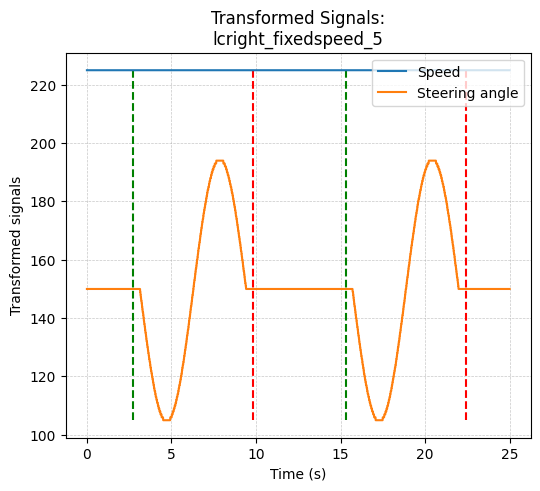

results/synthetic_lanechangecitos/lcright_fixedspeed_4.csv


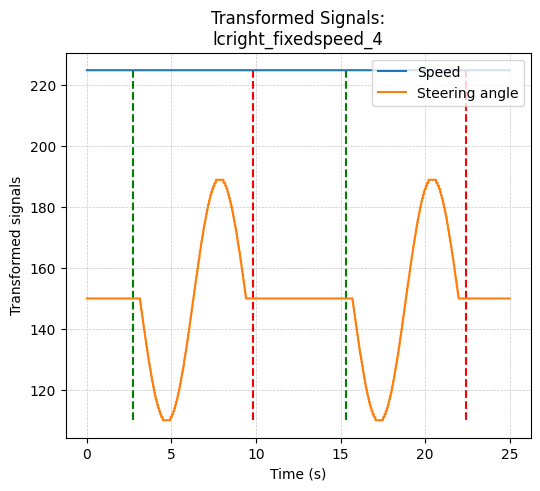

results/synthetic_lanechangecitos/lcright_fixedspeed_3.csv


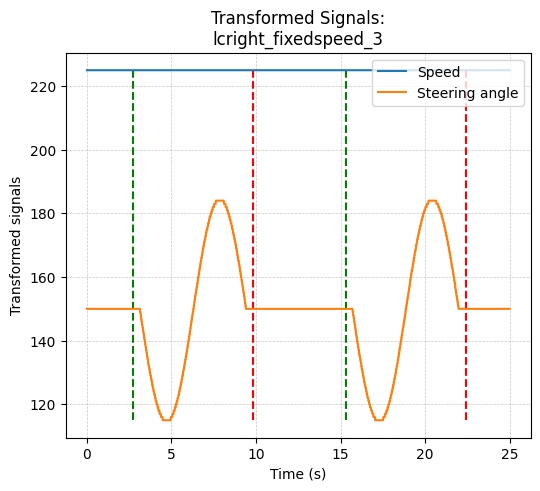

results/synthetic_lanechangecitos/lcright_fixedspeed_2.csv


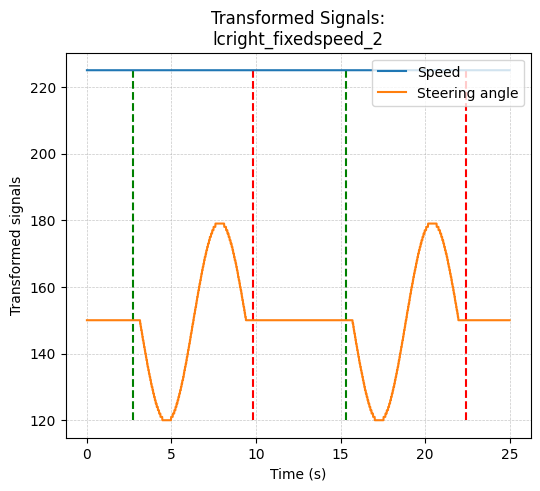

results/synthetic_lanechangecitos/lcright_fixedspeed_1.csv


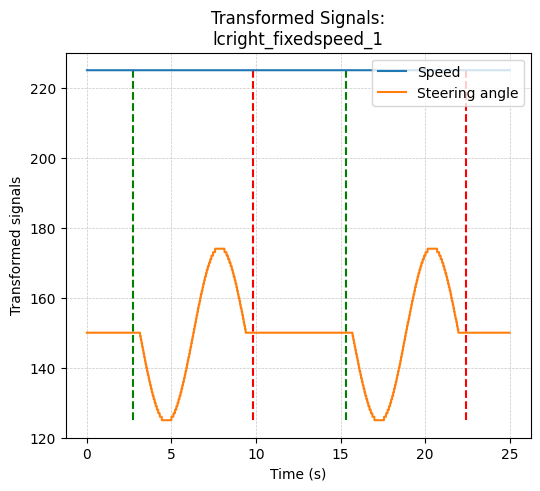

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_5.csv


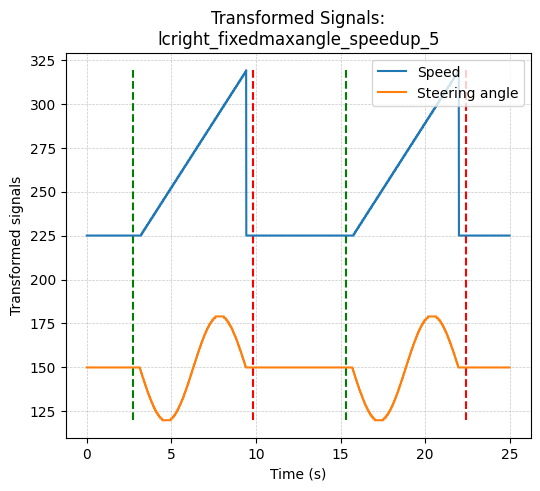

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_4.csv


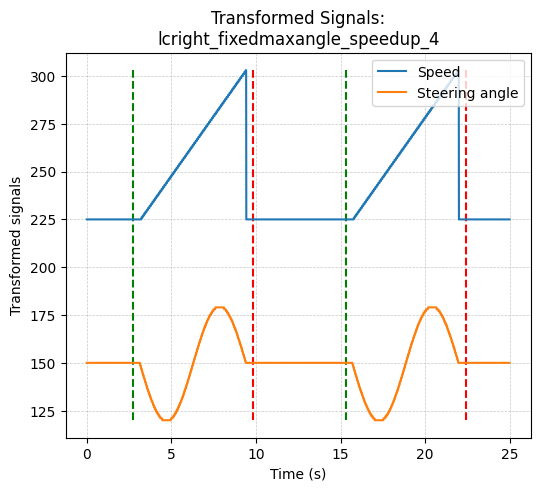

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_3.csv


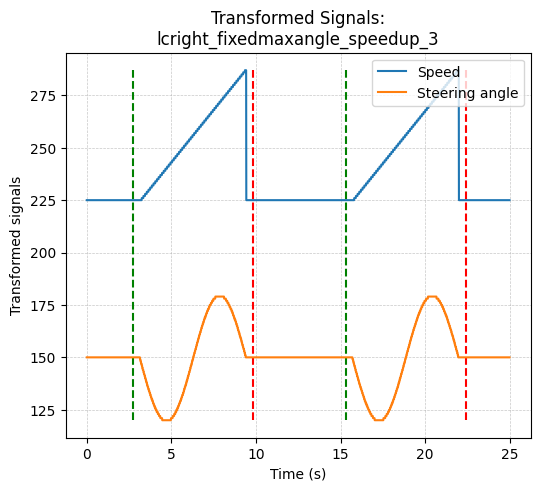

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_2.csv


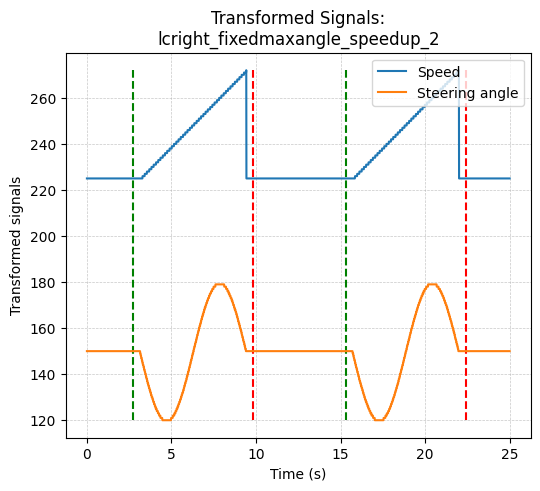

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_1.csv


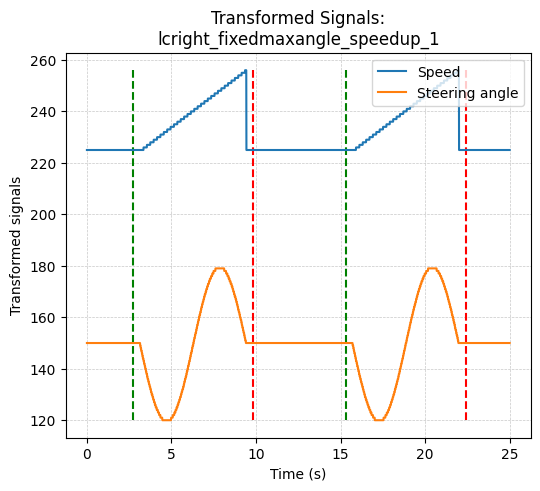

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_5.csv


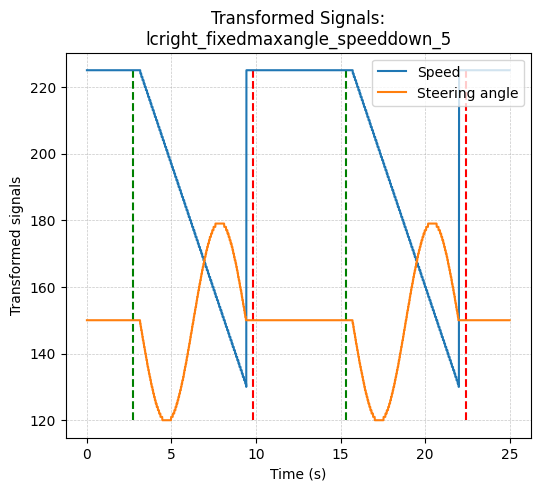

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_4.csv


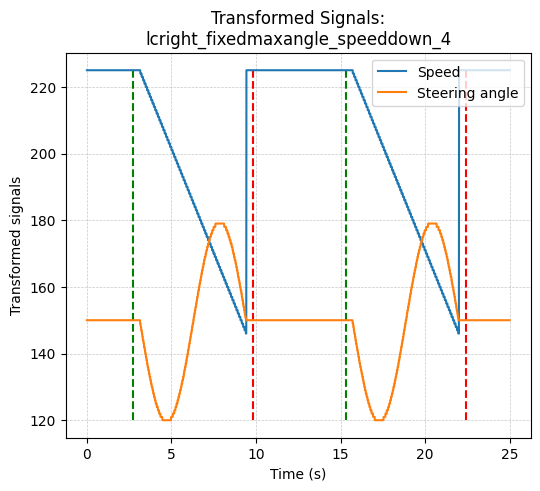

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_3.csv


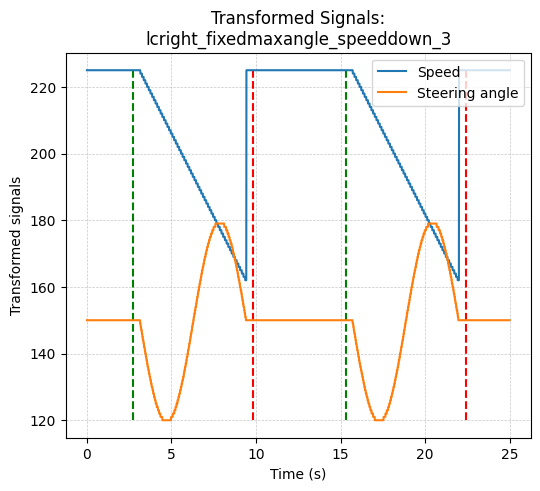

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_2.csv


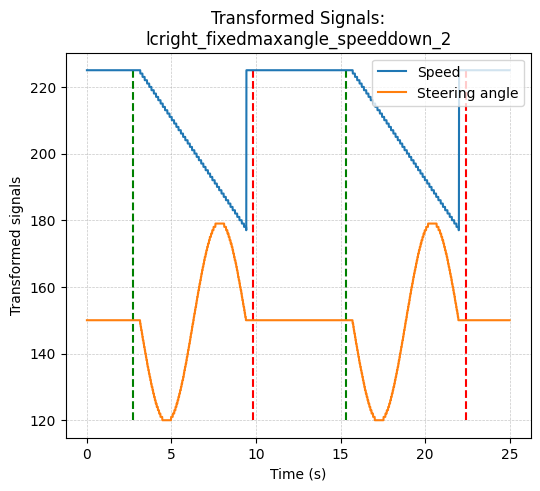

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_1.csv


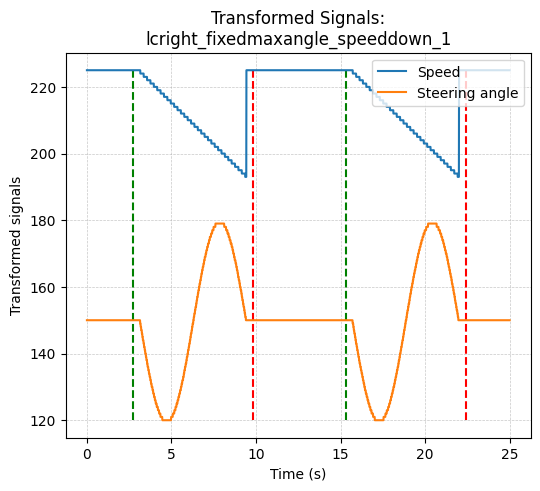

results/synthetic_lanechangecitos/lcright_fixedmaxangle_5.csv


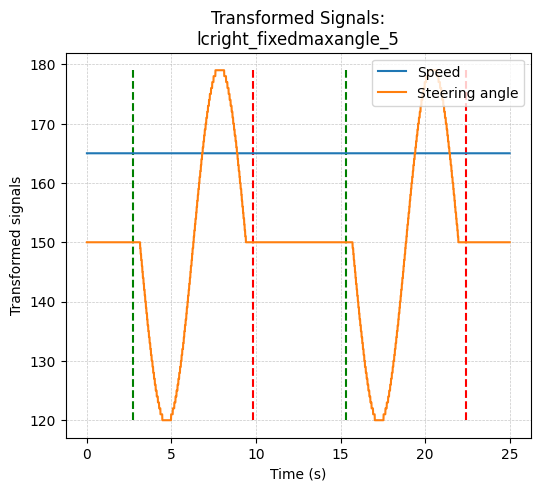

results/synthetic_lanechangecitos/lcright_fixedmaxangle_4.csv


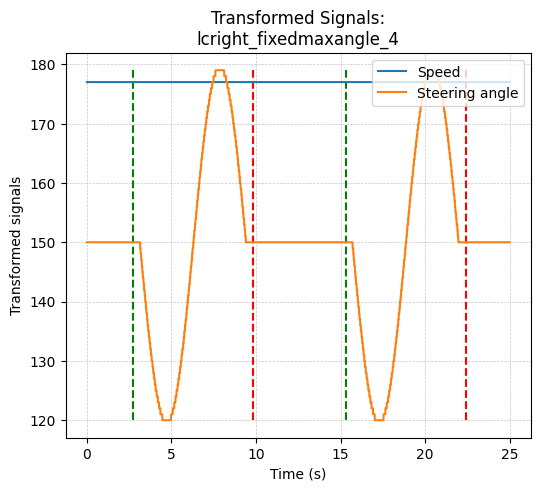

results/synthetic_lanechangecitos/lcright_fixedmaxangle_3.csv


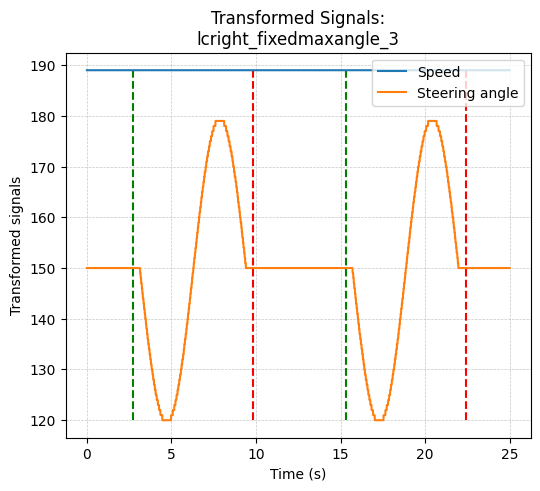

results/synthetic_lanechangecitos/lcright_fixedmaxangle_2.csv


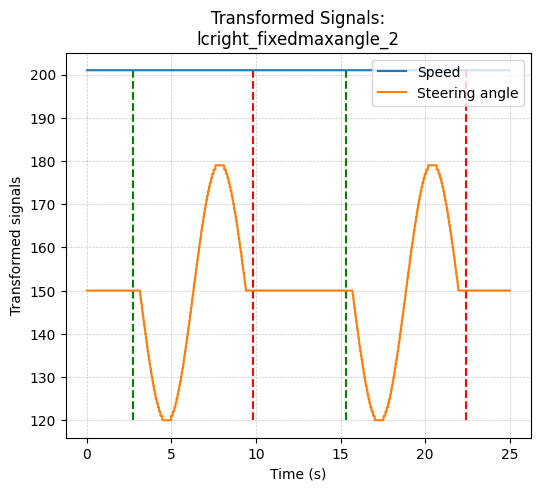

results/synthetic_lanechangecitos/lcright_fixedmaxangle_1.csv


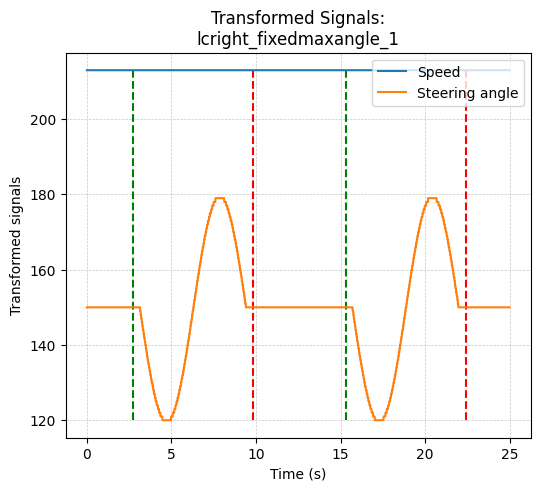

results/synthetic_lanechangecitos/lcleft_fixedspeed_5.csv


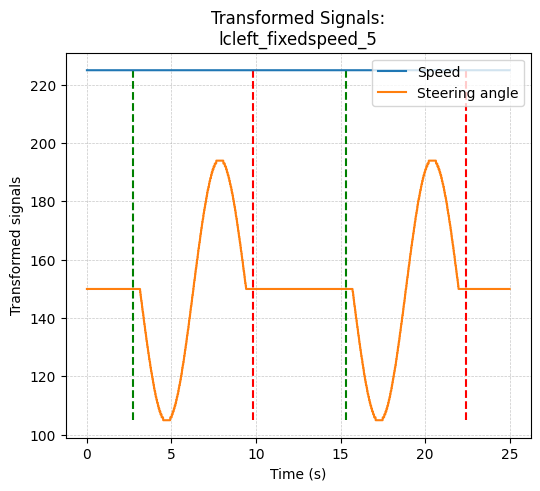

results/synthetic_lanechangecitos/lcleft_fixedspeed_4.csv


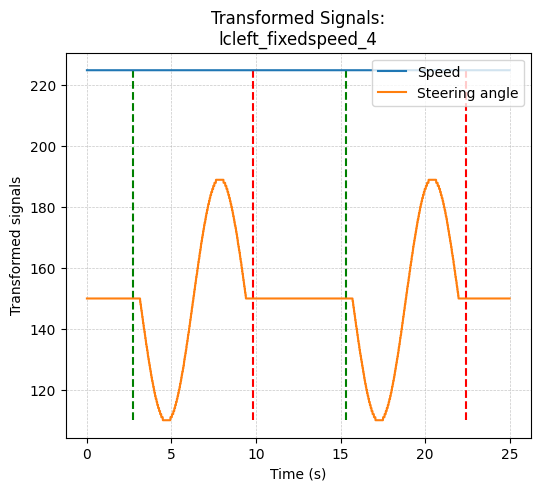

results/synthetic_lanechangecitos/lcleft_fixedspeed_3.csv


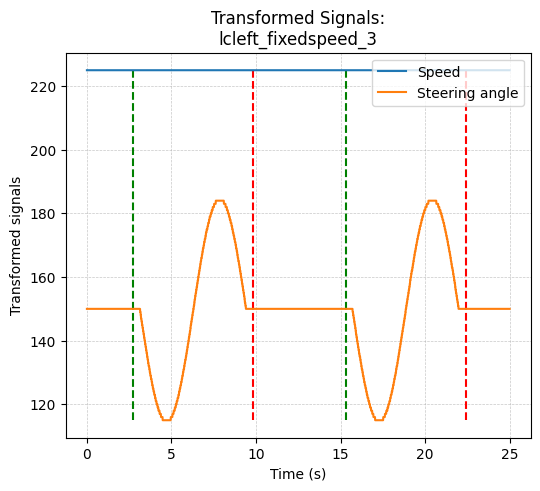

results/synthetic_lanechangecitos/lcleft_fixedspeed_2.csv


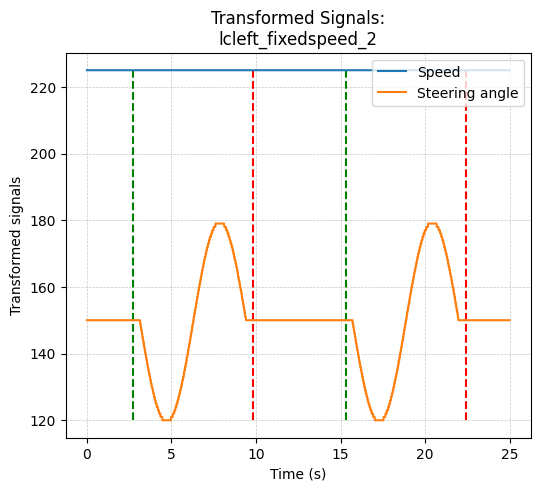

results/synthetic_lanechangecitos/lcleft_fixedspeed_1.csv


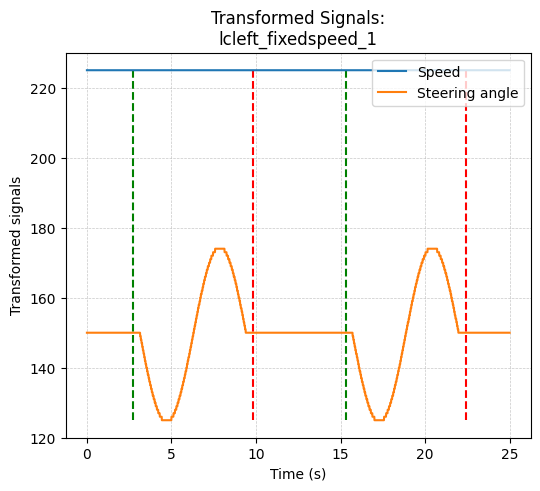

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_5.csv


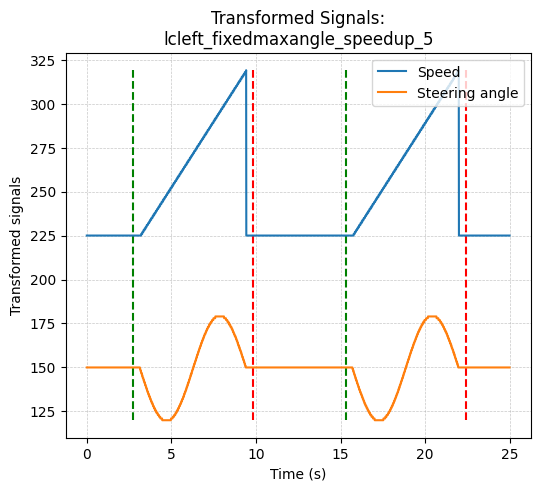

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_4.csv


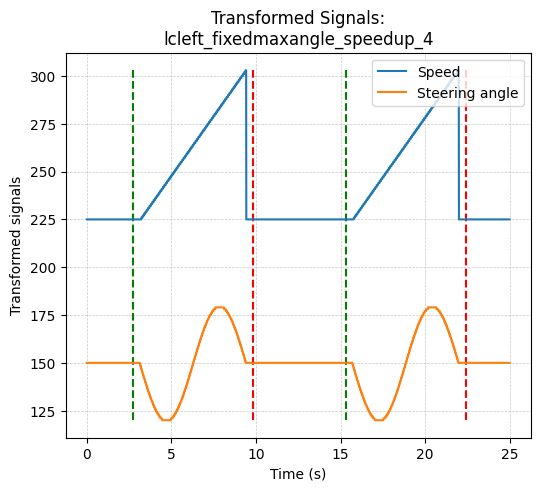

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_3.csv


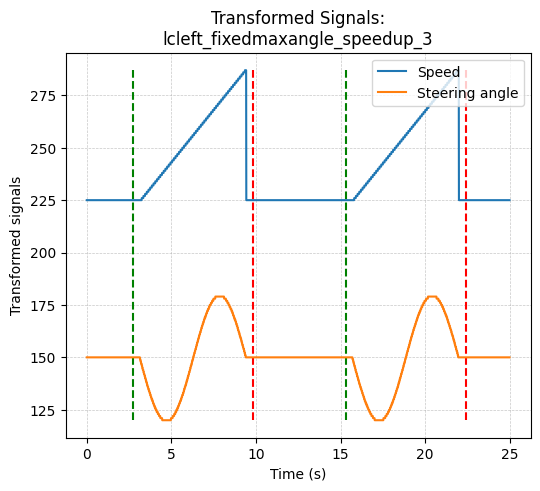

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_2.csv


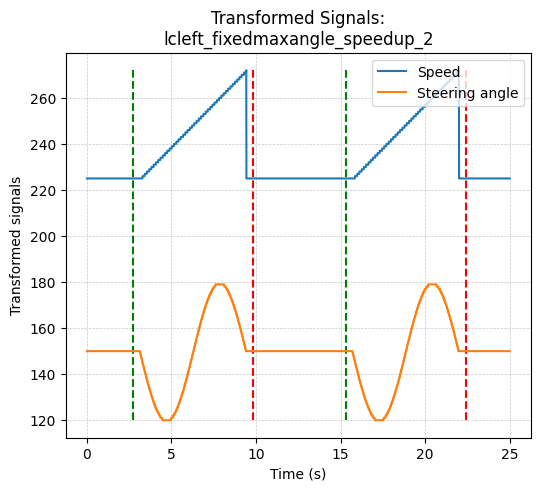

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_1.csv


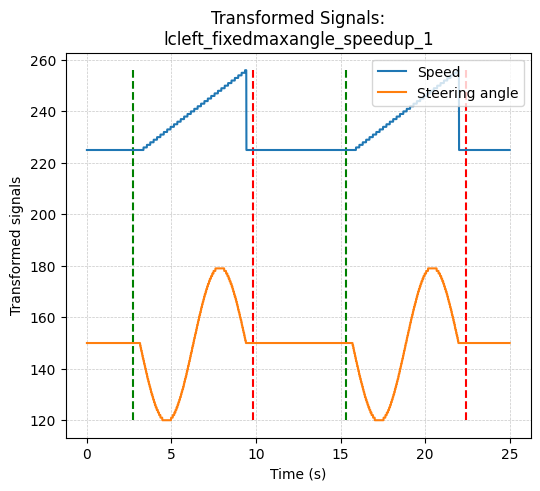

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_5.csv


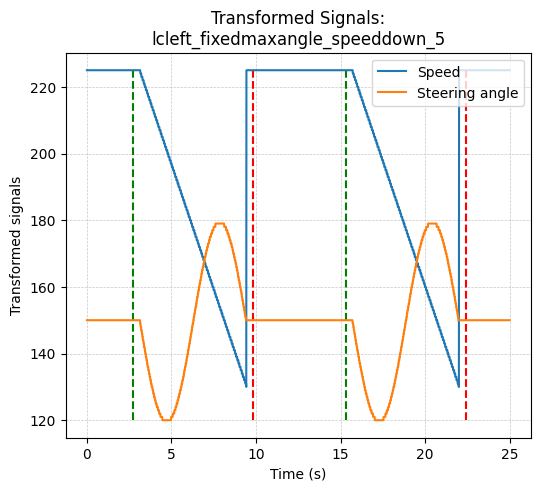

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_4.csv


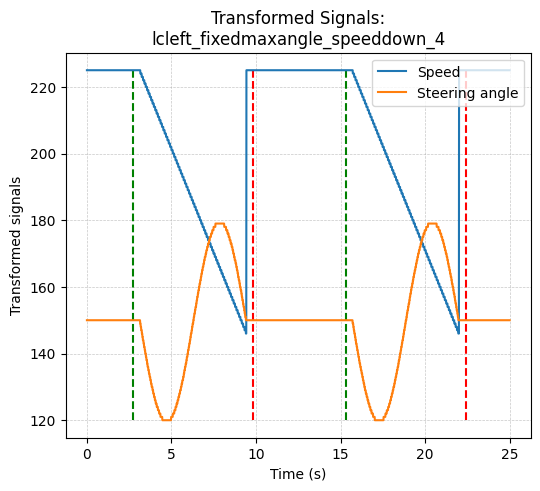

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_3.csv


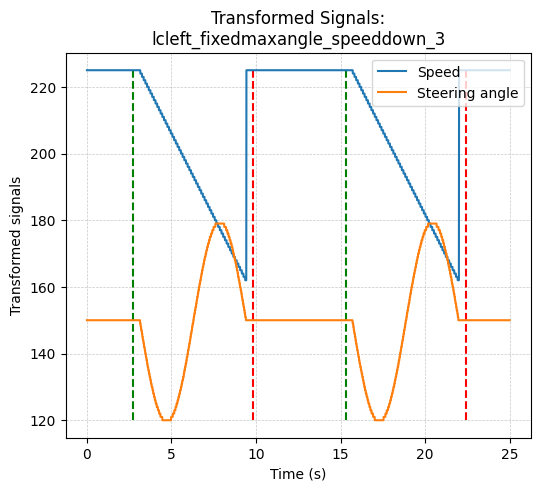

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_2.csv


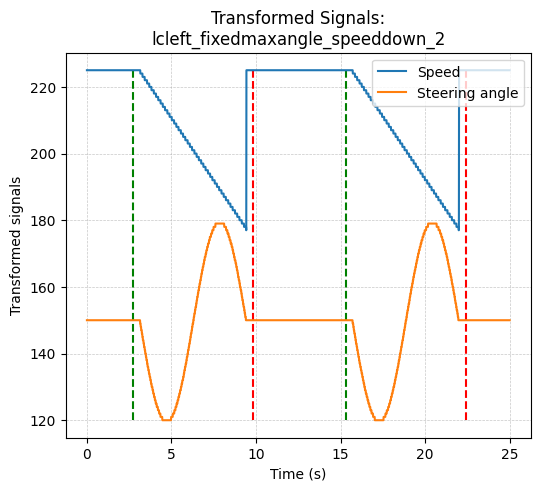

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_1.csv


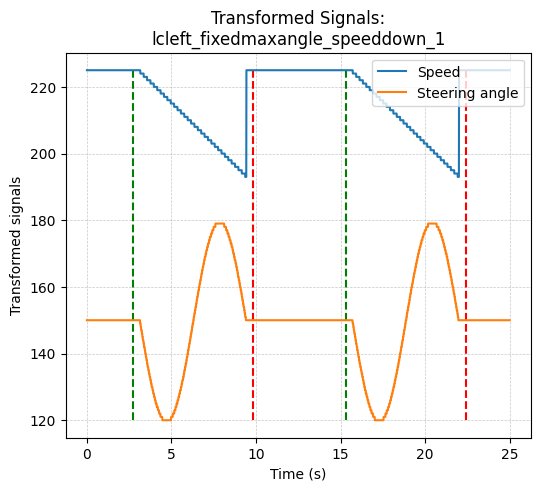

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_5.csv


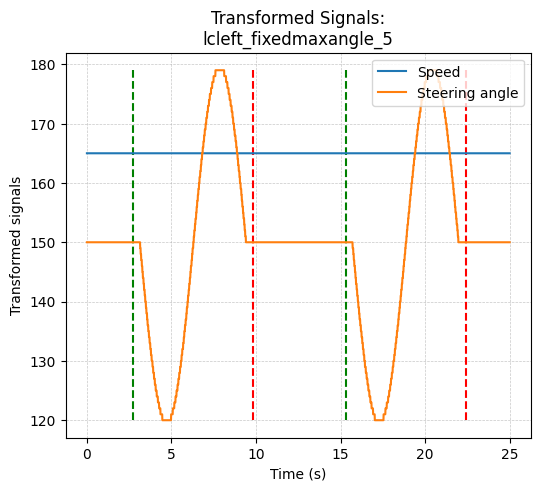

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_4.csv


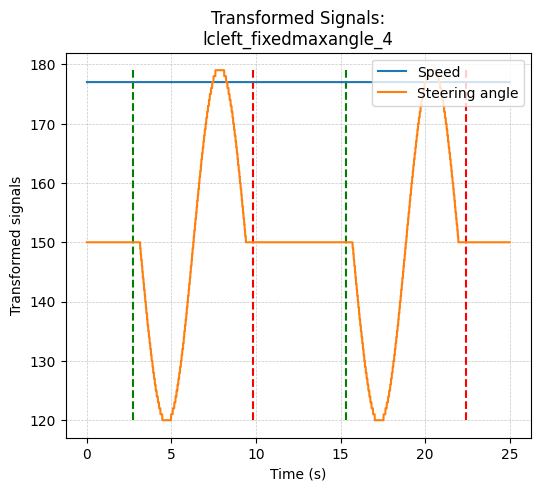

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_3.csv


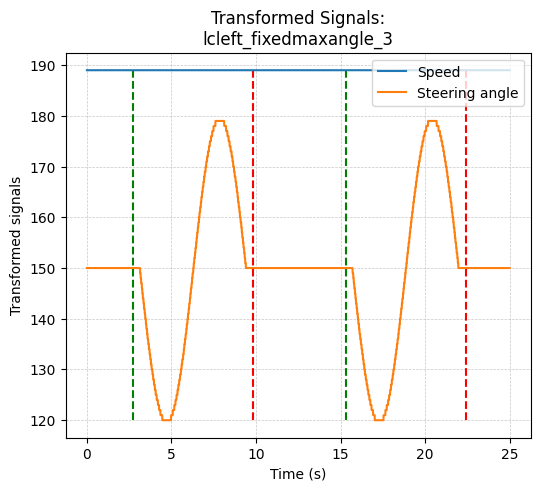

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_2.csv


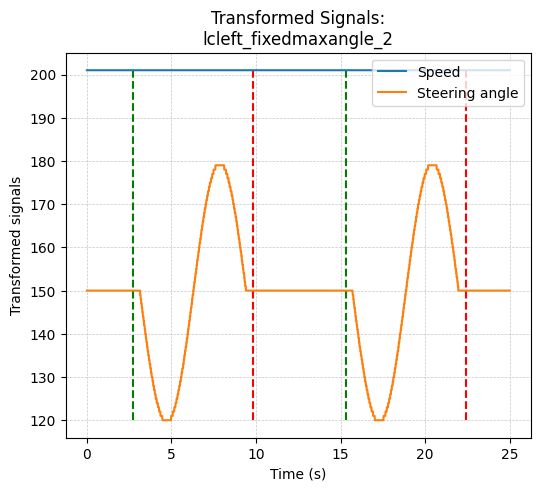

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_1.csv


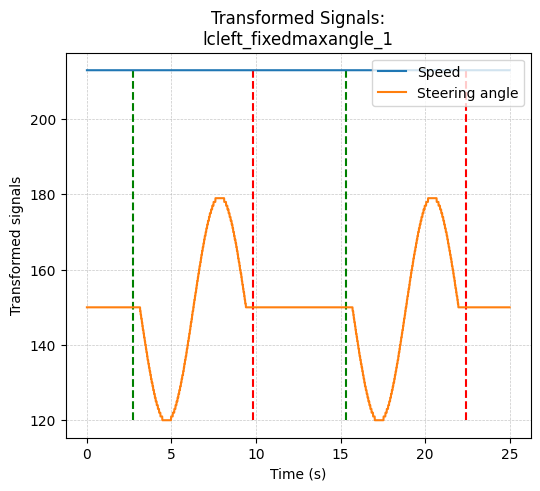

results/synthetic_lanechangecitos/lcright_fixedspeed_5.csv


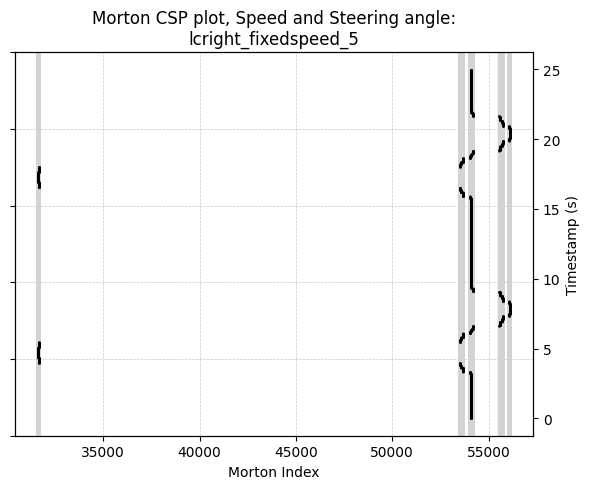

results/synthetic_lanechangecitos/lcright_fixedspeed_4.csv


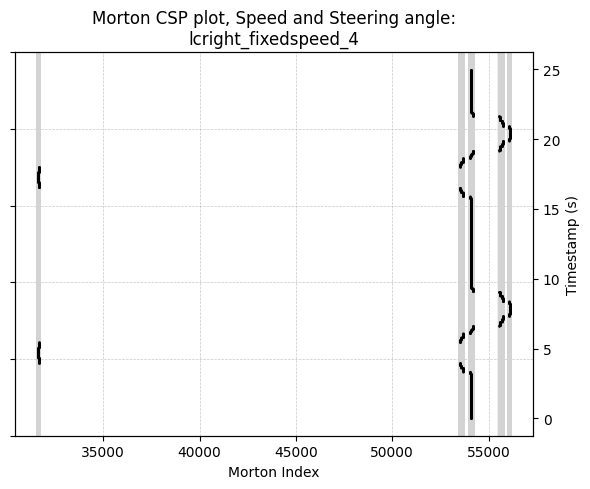

results/synthetic_lanechangecitos/lcright_fixedspeed_3.csv


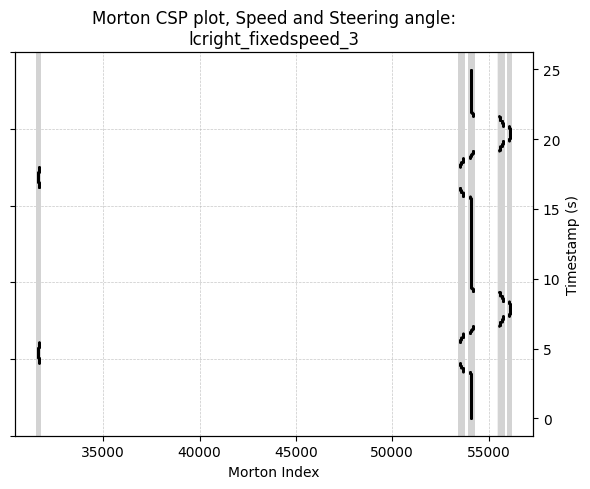

results/synthetic_lanechangecitos/lcright_fixedspeed_2.csv


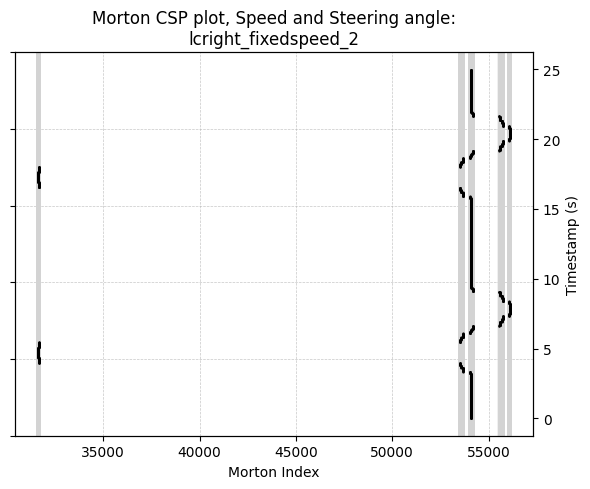

results/synthetic_lanechangecitos/lcright_fixedspeed_1.csv


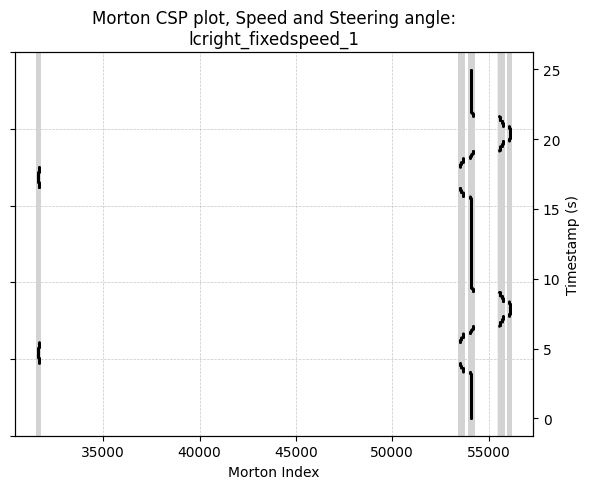

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_5.csv


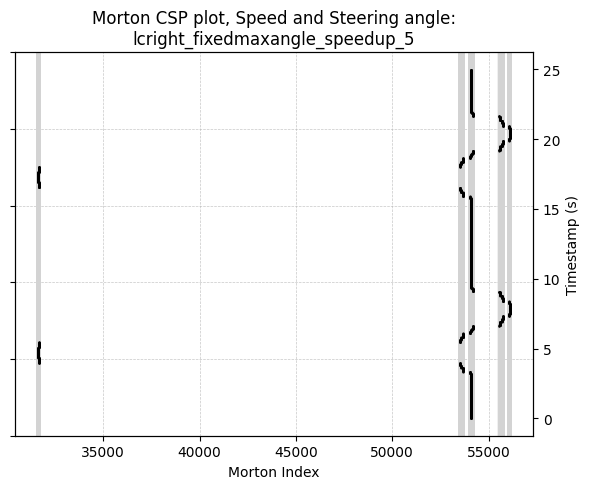

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_4.csv


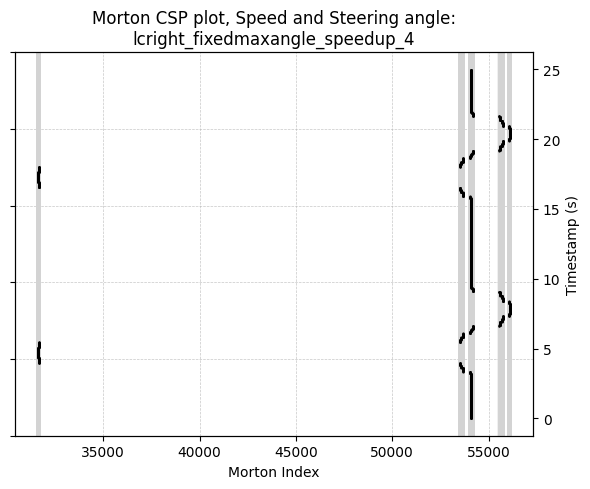

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_3.csv


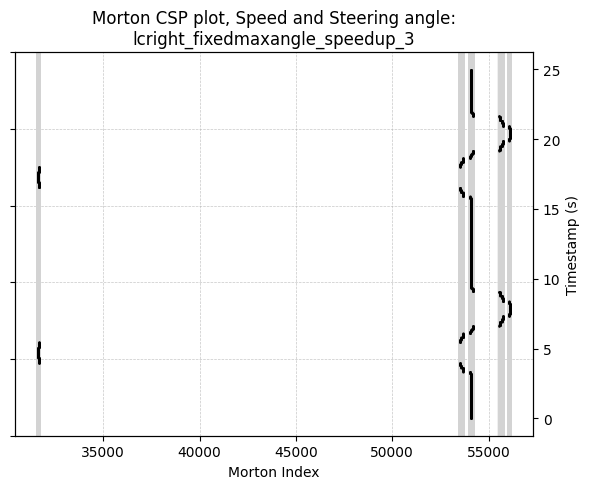

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_2.csv


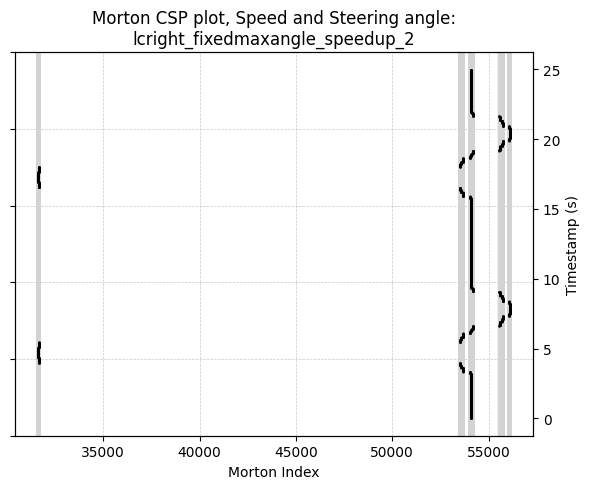

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_1.csv


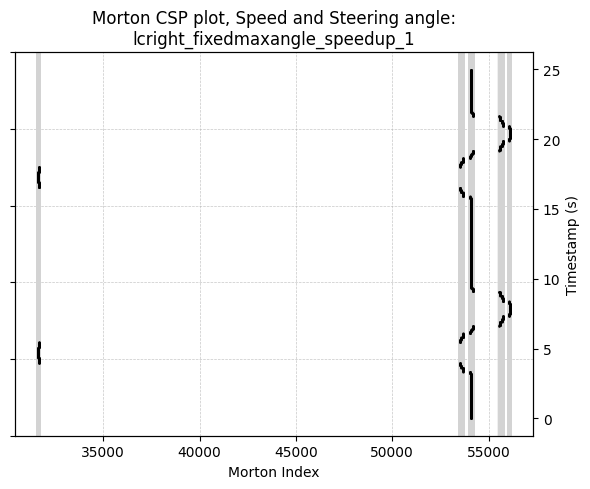

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_5.csv


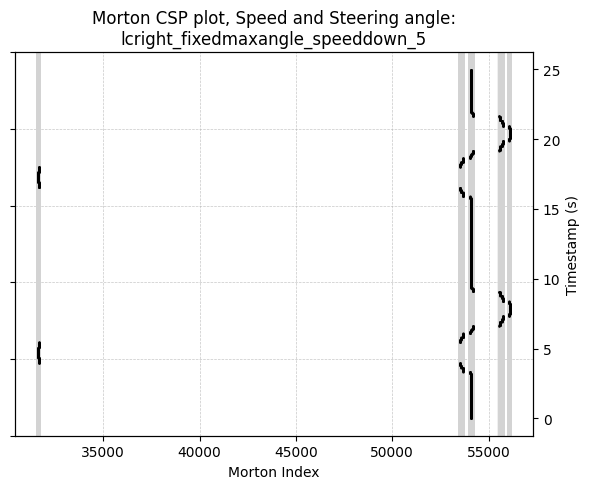

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_4.csv


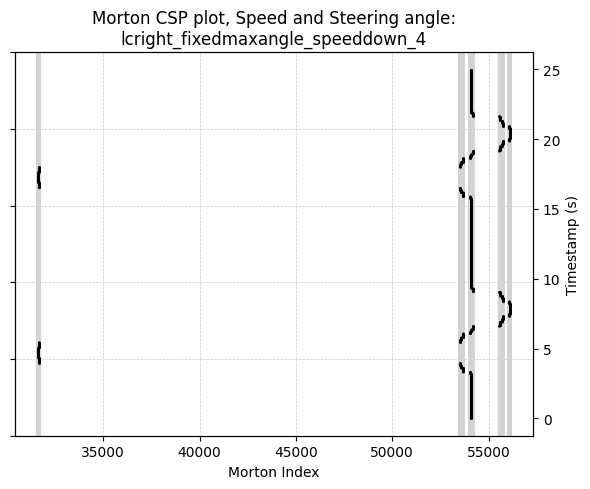

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_3.csv


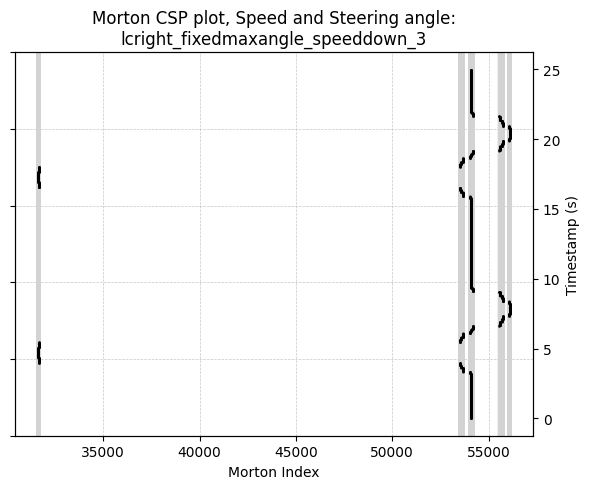

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_2.csv


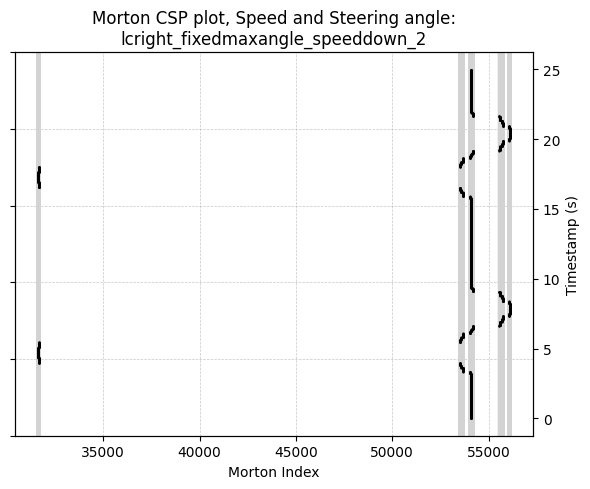

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_1.csv


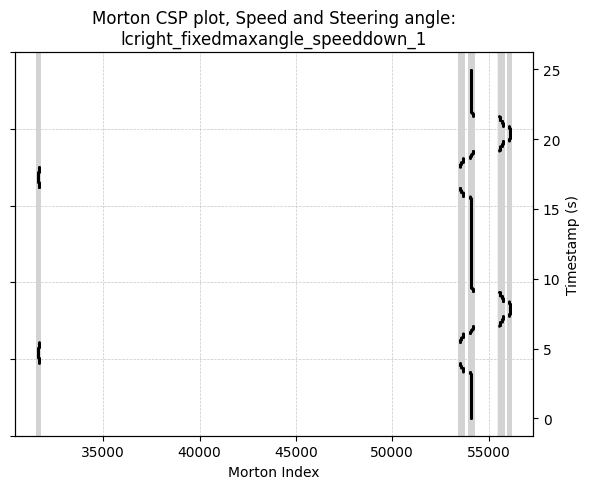

results/synthetic_lanechangecitos/lcright_fixedmaxangle_5.csv


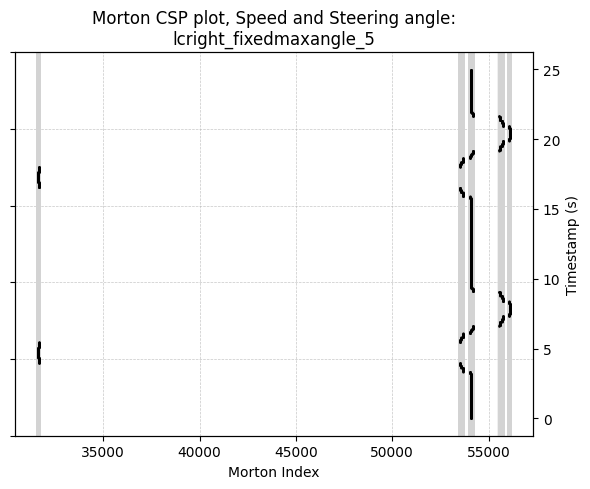

results/synthetic_lanechangecitos/lcright_fixedmaxangle_4.csv


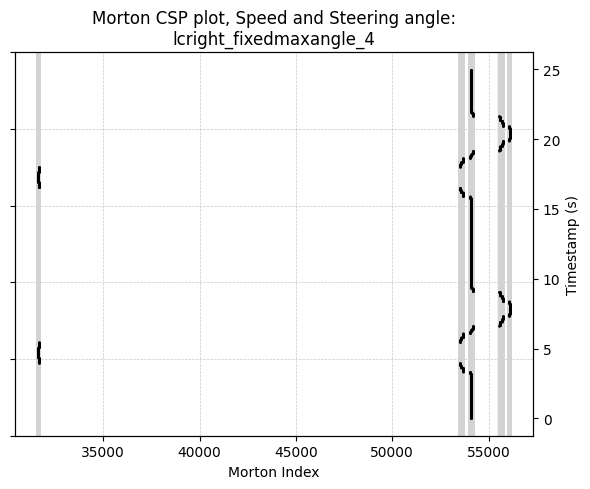

results/synthetic_lanechangecitos/lcright_fixedmaxangle_3.csv


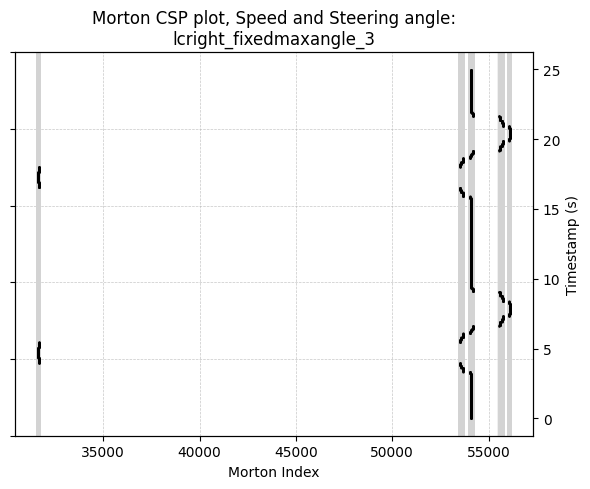

results/synthetic_lanechangecitos/lcright_fixedmaxangle_2.csv


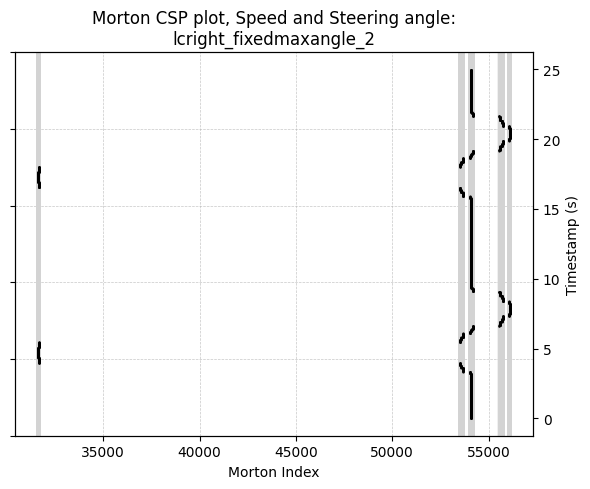

results/synthetic_lanechangecitos/lcright_fixedmaxangle_1.csv


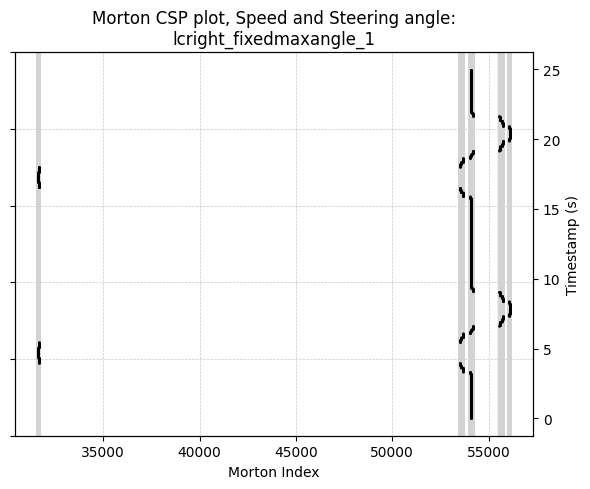

results/synthetic_lanechangecitos/lcleft_fixedspeed_5.csv


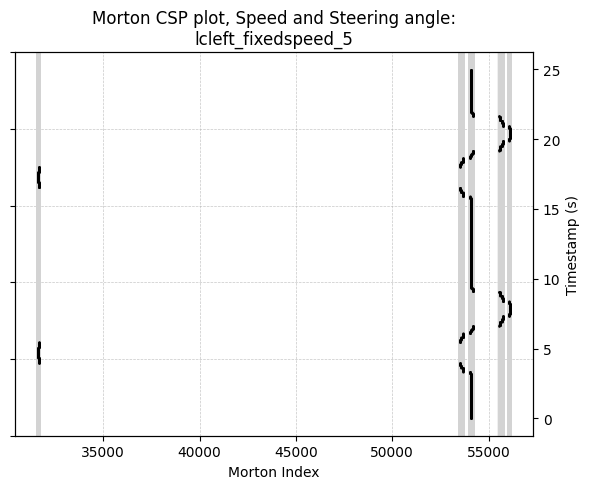

results/synthetic_lanechangecitos/lcleft_fixedspeed_4.csv


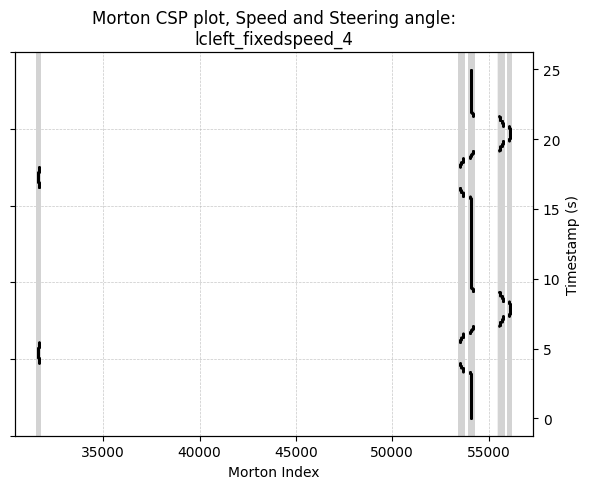

results/synthetic_lanechangecitos/lcleft_fixedspeed_3.csv


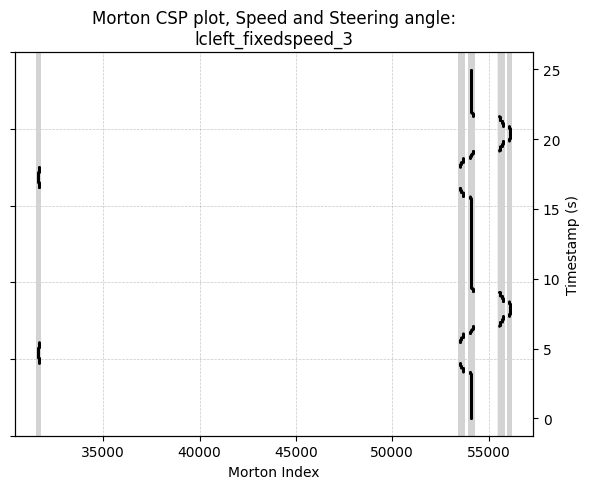

results/synthetic_lanechangecitos/lcleft_fixedspeed_2.csv


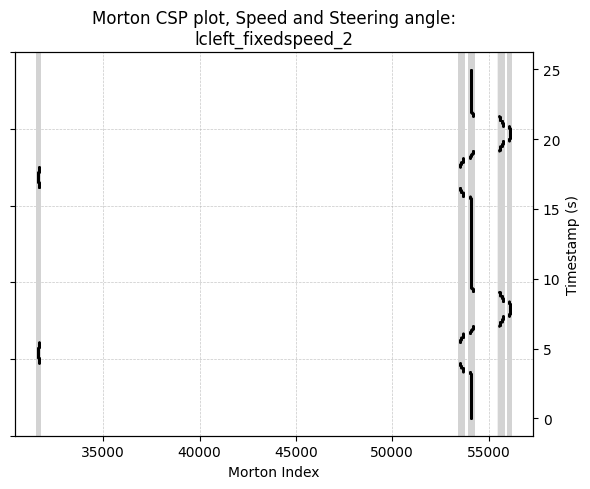

results/synthetic_lanechangecitos/lcleft_fixedspeed_1.csv


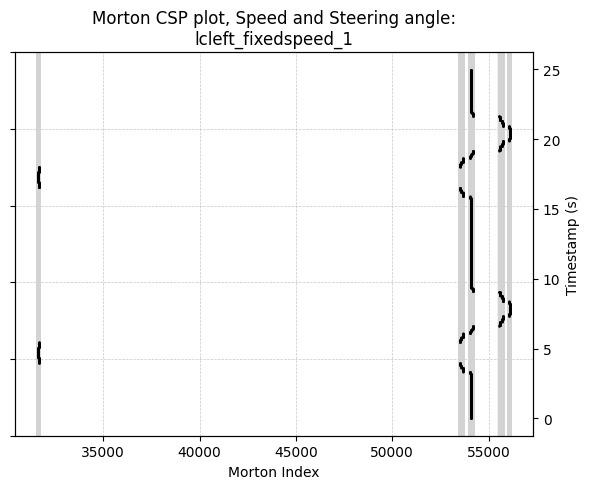

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_5.csv


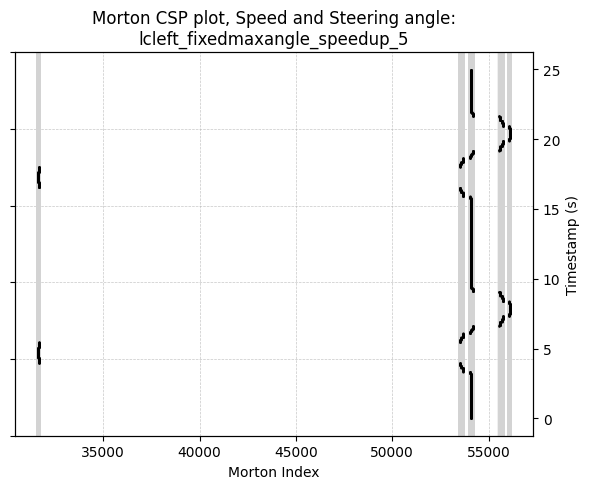

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_4.csv


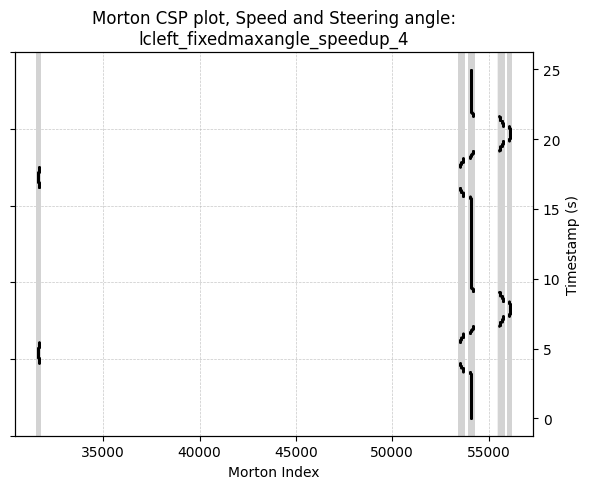

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_3.csv


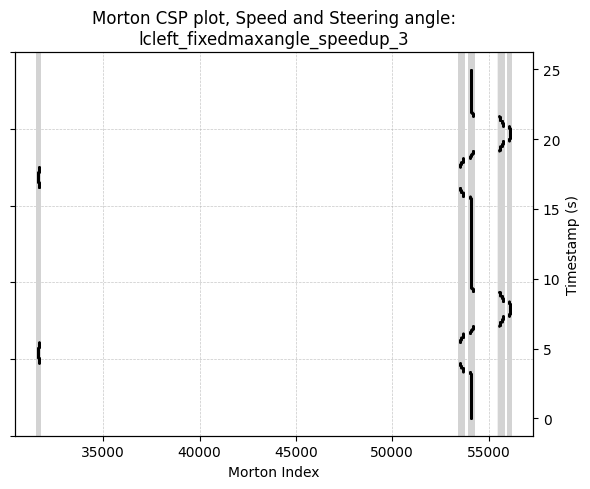

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_2.csv


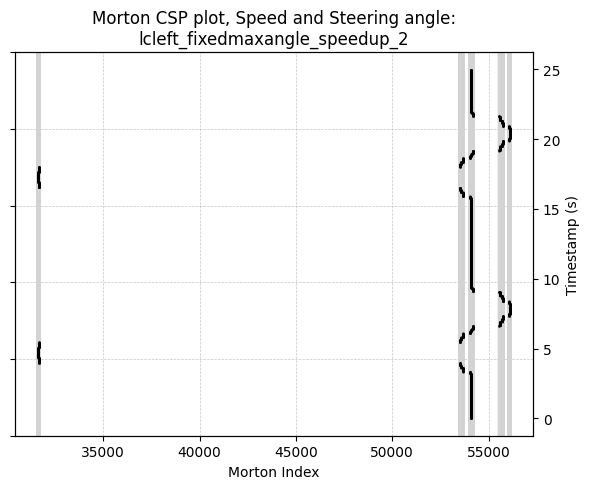

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_1.csv


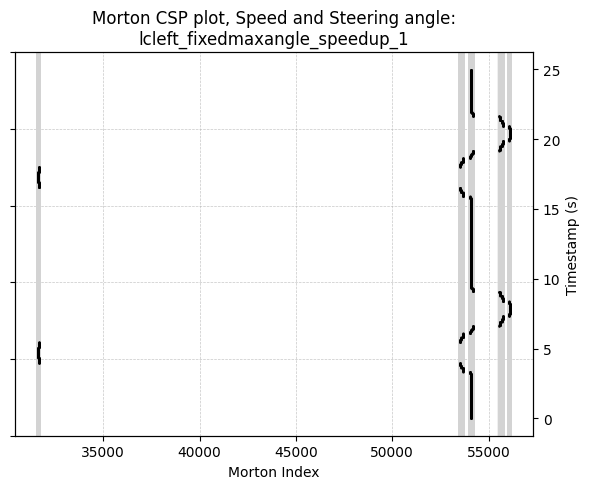

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_5.csv


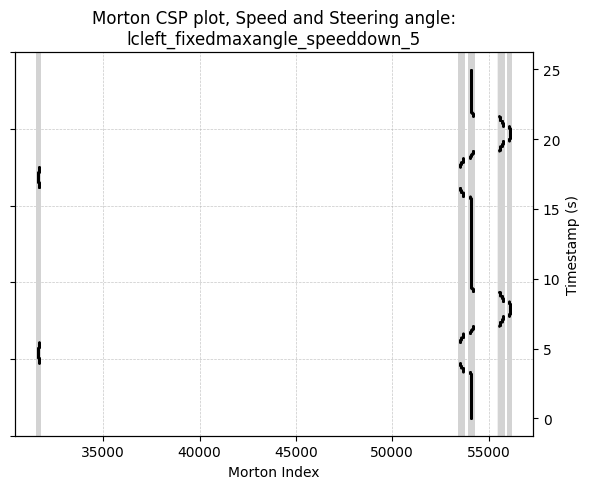

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_4.csv


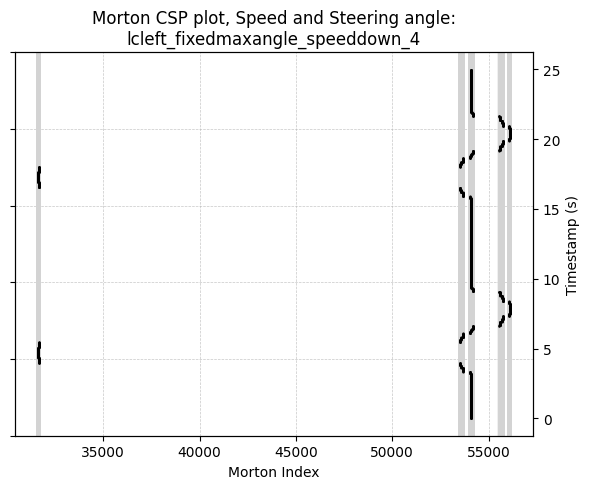

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_3.csv


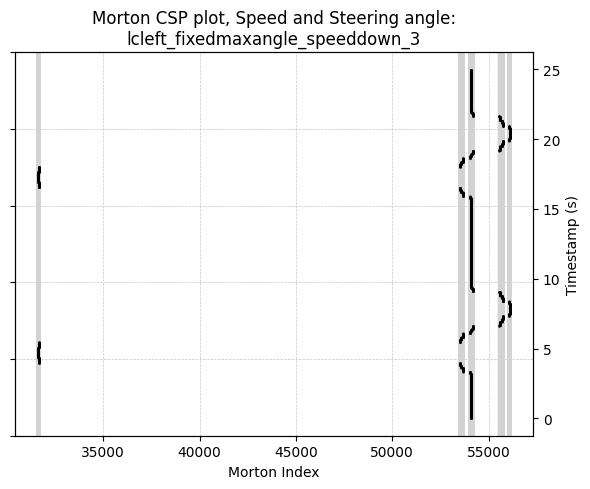

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_2.csv


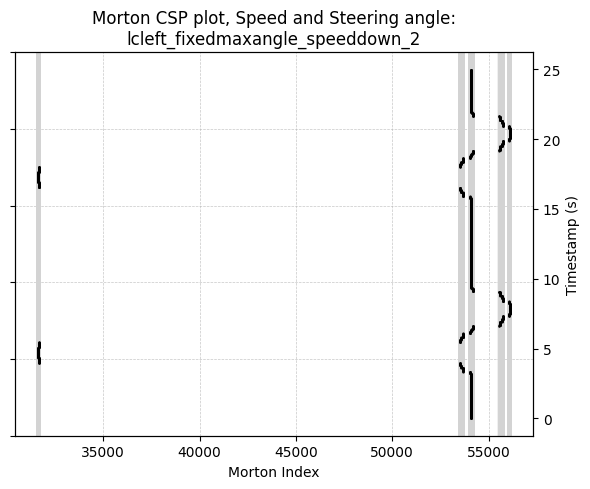

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speeddown_1.csv


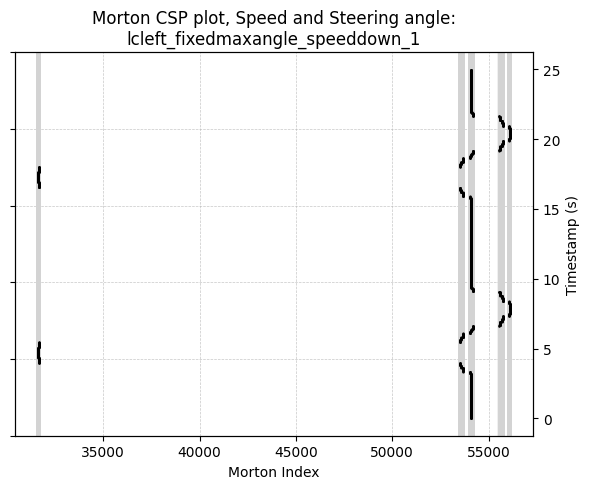

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_5.csv


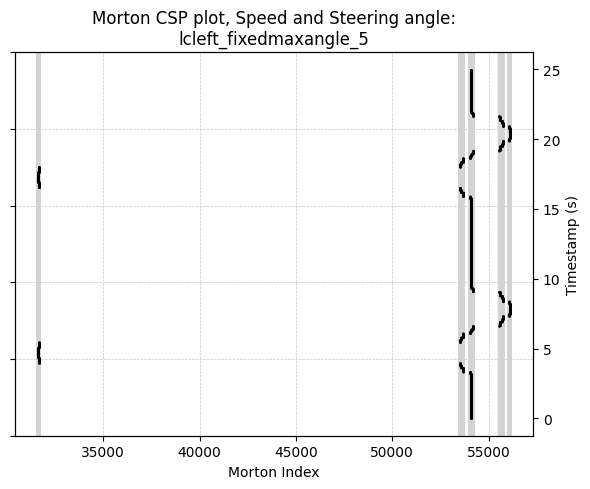

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_4.csv


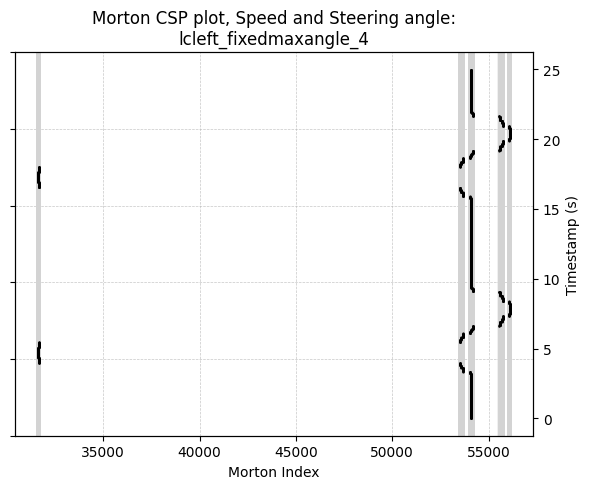

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_3.csv


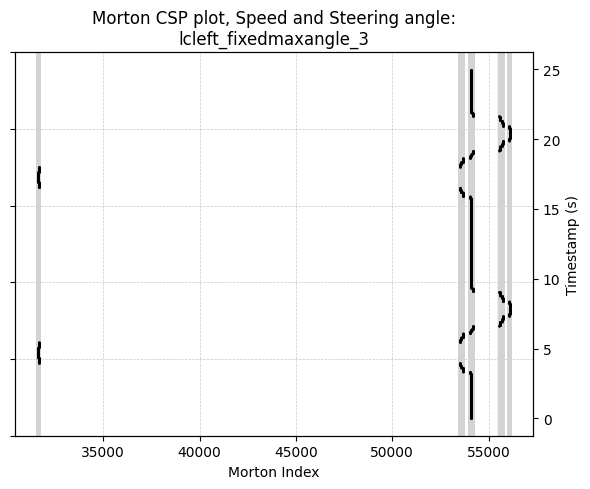

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_2.csv


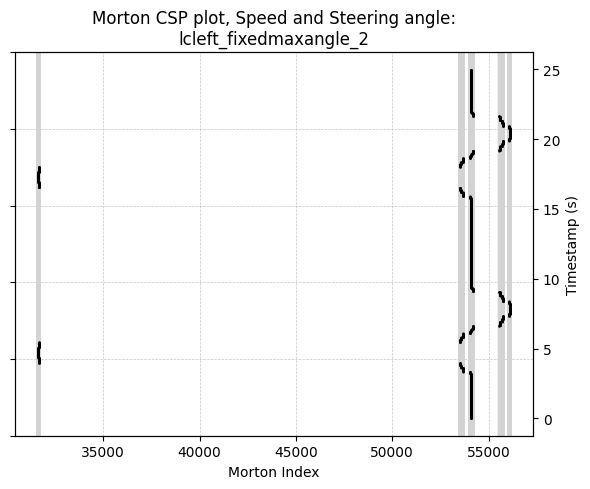

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_1.csv


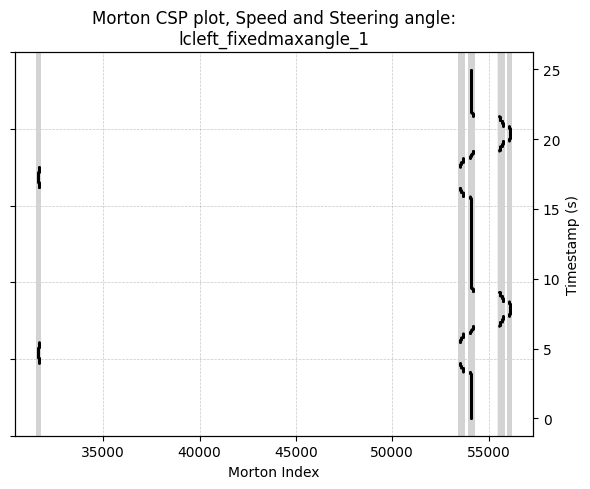

[]

In [11]:
plot_transformed_signals(data_files=data_files, scales_dict=scales, offsets_dict=offsets)
plot_morton(data_files=data_files)

In [ ]:
# ===============================
# Load Morton indices
# ===============================

file_basenames = []
csps = {}
csps_normalized = {}
speeds = {}
for file_path in data_files:
    if ".csv" not in file_path:
        continue
    
    print(file_path)
    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    file_basenames.append(file_basename)

    data = pd.read_csv(file_path, sep=";")
    morton= np.array(data['Morton_Index'].tolist())
    morton_normalized = morton / np.sqrt(np.dot(morton, morton))

    csps[file_basename] = np.copy(morton)
    speeds[file_basename] = data['Speed (m/s)'].iloc[0]
    csps_normalized[file_basename] = np.copy(morton_normalized)
    
    
file_basenames.sort()

results/synthetic_lanechangecitos/lcright_fixedspeed_5.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_4.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_3.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_2.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_1.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_5.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_4.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_3.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_2.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_1.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_5.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_4.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_3.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_2.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_1

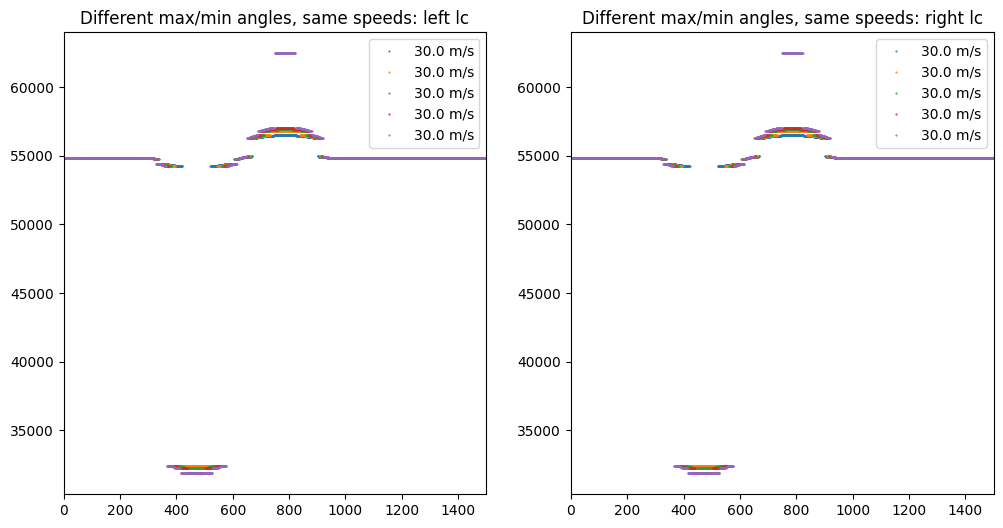

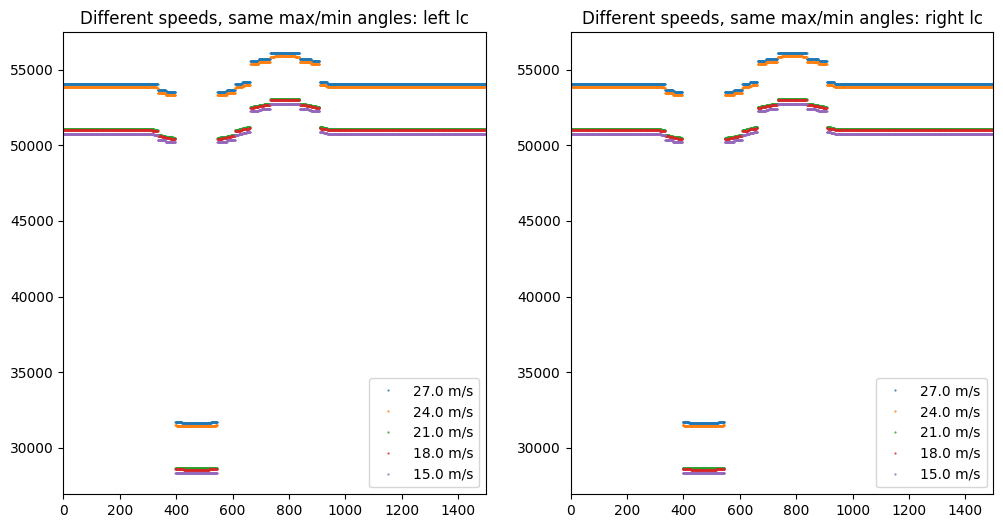

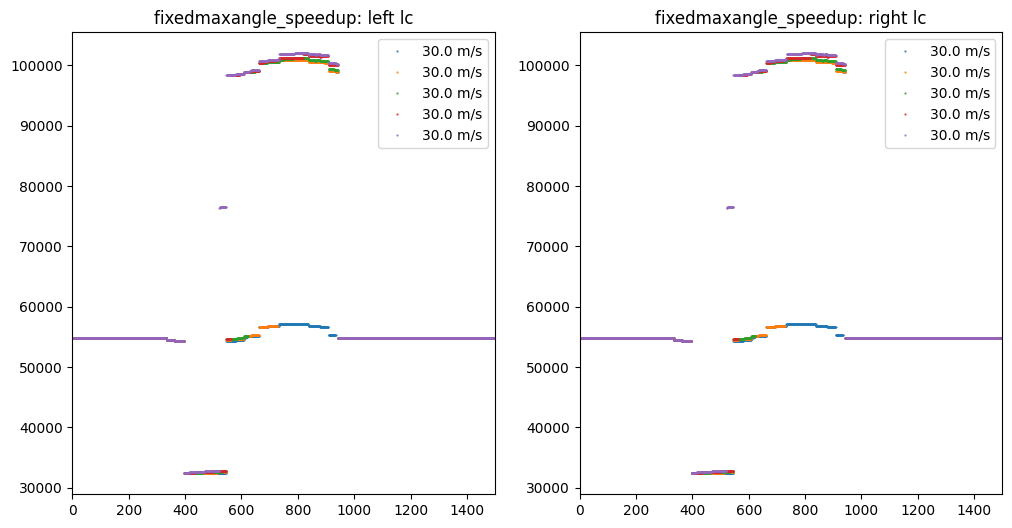

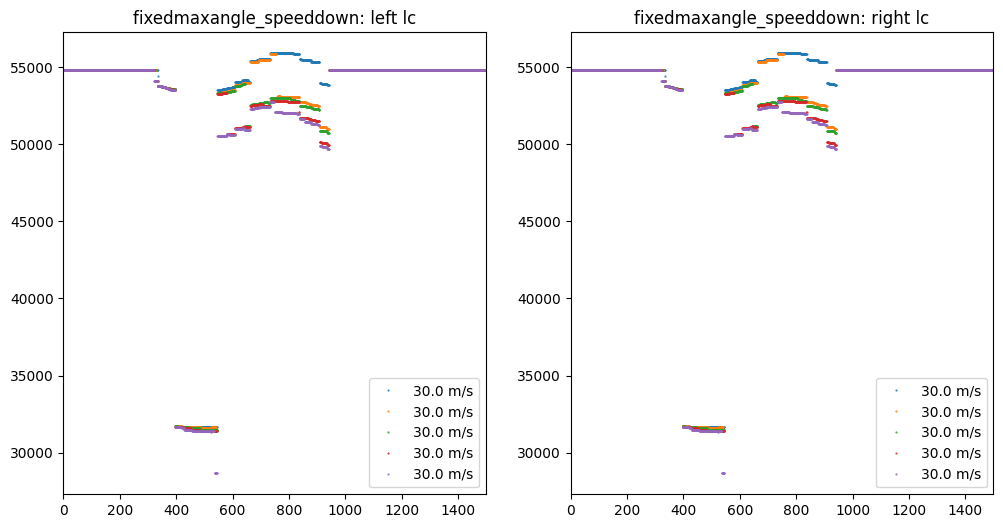

In [8]:
nrecords = 5
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
for i in range(1, nrecords + 1 ):
    left_lc = 'lcleft_' + 'fixedspeed' + f'_{i}'
    right_lc = 'lcright_' + 'fixedspeed' + f'_{i}'

    ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
    ax[1].plot(csps[right_lc], label=f'{speeds[right_lc]} m/s', ls='none', marker='o', ms=0.5)

    ax[0].set_title('Different max/min angles, same speeds: left lc')
    ax[1].set_title('Different max/min angles, same speeds: right lc')
    ax[0].set_xlim(0,1500)
    ax[1].set_xlim(0,1500)
    ax[0].legend()
    ax[1].legend()

plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
for i in range(1, nrecords +1):
    left_lc = 'lcleft_' + 'fixedmaxangle' + f'_{i}'
    right_lc = 'lcright_' + 'fixedmaxangle' + f'_{i}'

    ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
    ax[1].plot(csps[right_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)


    ax[0].set_title('Different speeds, same max/min angles: left lc')
    ax[1].set_title('Different speeds, same max/min angles: right lc')
    ax[0].set_xlim(0,1500)
    ax[1].set_xlim(0,1500)
    ax[0].legend()
    ax[1].legend()

plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
for i in range(1, nrecords + 1 ):
    left_lc = 'lcleft_' + 'fixedmaxangle_speedup' + f'_{i}'
    right_lc = 'lcright_' + 'fixedmaxangle_speedup' + f'_{i}'

    ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
    ax[1].plot(csps[right_lc], label=f'{speeds[right_lc]} m/s', ls='none', marker='o', ms=0.5)

    ax[0].set_title('fixedmaxangle_speedup: left lc')
    ax[1].set_title('fixedmaxangle_speedup: right lc')
    ax[0].set_xlim(0,1500)
    ax[1].set_xlim(0,1500)
    ax[0].legend()
    ax[1].legend()
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
for i in range(1, nrecords + 1 ):
    left_lc = 'lcleft_' + 'fixedmaxangle_speeddown' + f'_{i}'
    right_lc = 'lcright_' + 'fixedmaxangle_speeddown' + f'_{i}'

    ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
    ax[1].plot(csps[right_lc], label=f'{speeds[right_lc]} m/s', ls='none', marker='o', ms=0.5)

    ax[0].set_title('fixedmaxangle_speeddown: left lc')
    ax[1].set_title('fixedmaxangle_speeddown: right lc')
    ax[0].set_xlim(0,1500)
    ax[1].set_xlim(0,1500)
    ax[0].legend()
    ax[1].legend()

plt.show()
